<h1>MALIS Lab Session 3 - Fall 2019</h1>

The aim of this lab is to practice with Support Vector Machines (SVM), and in particular with the PEGASOS (Primal Estimated sub-GrAdient SOlver for SVM) algorithm. PEGASOS is a fast stochastic sub-gradient descent algorithm for solving the primal optimization problem cast by an SVM. In the first part of this lab, you will be to implement PEGASOS. As it is based on a primal problem, it is only adapted to linear kernels; the authors of PEGASOS proposed a way to use other non-linear kernels, at the price of time efficiency. Therefore in the second part of the lab, instead of implementing that less efficient version of PEGASOS, you will work on a features mapping method that will allow you to separate non-linearly separable datasets using PEGASOS. You will test your implementations on four datasets.

Experiments should be made by groups of two students. Each group should produce a Jupyter Notebook with all their results and comments. We strongly encourage the addition of plots and visual representations to the report, bearing in mind that comments on graphical data are still necessary. Code for adding images to your notebook: ```<img src="path/to/image.png" />```.

Submit your complete notebook as an archive (tar -cf <last_name_1>_<last_name_2>_notebook.tar lab2/). 

**Deadline for submitting your notebook:** 23 December 2019 23:59 via Moodle.

<h2>Introduction</h2>
There are three parts to this lab session. 

1. A part on PEGASOS where you are asked to implement the stochastic version of PEGASOS;

2. A part on features mapping.

Data are 2D. You can visualize them by running the following cell (red dots are labeled -1 and green dots are labeled 1).

Dataset: data/dataset1.txt


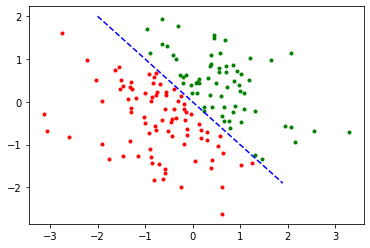

Dataset: data/dataset2.txt


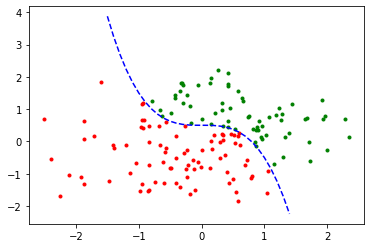

Dataset: data/dataset3.txt


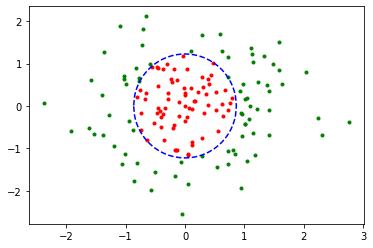

Dataset: data/dataset4.txt


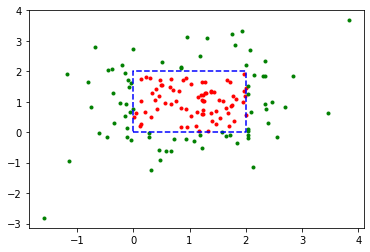

In [8]:
from utils import print_dataset
print_dataset("data/dataset1.txt")
print_dataset("data/dataset2.txt")
print_dataset("data/dataset3.txt")
print_dataset("data/dataset4.txt")

<h4>Question 1</h4>
According to the above plots, do these datasets seem to be linearly separable? On which of these datasets do you expect a linear SVM to perform well? On which ones do you think it will perform badly?

<h4>Your answer</h4>
According to the previous plot, only dataset1 is linearly separable since we can find a hyperplan (a line in this case) the can separete the different classes (red and green dots). For the other datasets, it's impossible to find such an hyperplan.<br>
A linear SVM (without applying kernel) is expected to perform better on linearly separable datasets (we can even reach an accuracy of 100%), that means on the first dataset, slightly worse on the second one and much worse on the last 2 ones.

<h2>Part 1: PEGASOS</h2>

<h3>How PEGASOS works</h3>

<i>That sub-part gives some intuition about how PEGASOS can actually find the solution of a problem cast by a linear SVM. Reading it is not required to do the lab, but we encourage you to have a look at it as it may help you for your implementation.</i>

Let us assume that given a set $S = \lbrace (x_i, y_i) \rbrace$ where $x_i \in \mathbb{R}^n$ and $y_i \in \lbrace -1, 1 \rbrace$, we want to find a solution of the following problem

$$\min_{w, b} \frac{1}{2} \Vert w \Vert^2 + C \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $C$ is a non-zero hyperparameter controlling the "softness" of the margin (the lower the $C$ the softer the margin), or equivalently

$$\min_{w, b} \frac{\lambda}{2} \Vert w \Vert^2 + \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $\lambda$ replaces $C$ (the higher the $\lambda$ the softer the margin). We can get rid of the bias term $b$ by adding a constant feature to all the $x_i$ (we can assume without loss of generality that the value of the constant is 1) and by replacing $w$ by the concatenation of $w$ and $b$. In that setup, the optimization problem becomes (with $\tilde{w} = [w; b]$ and $\tilde{x_i} = [x_i; 1]$)

$$\min_{\tilde{w}} \frac{\lambda}{2} \Vert \tilde{w} \Vert^2 + \sum_i \max(0, 1-y_i(\tilde{w}^T\tilde{x_i})).$$

You can notice that the optimization problem we obtained is slightly different from the one we stated before, as $\Vert \tilde{w} \Vert^2$ should be replaced by $\Vert \tilde{w} \Vert^2 - b^2$. However, in practice, that difference has very few importance. Therefore in the following we will assume that $x_i \in \mathbb{R}^{n+1}$, $w \in \mathbb{R}^{n+1}$, and that the last feature of $x_i$ is always equal to 1. As we will work on the stochastic variant of PEGASOS, we will consider the following objective:

$$\min_{w_t} \frac{\lambda}{2} \Vert w_t \Vert^2 + \max(0, 1-y_{i_t}(w_t^Tx_{i_t}))$$

where $(x_{i_t}, y_{i_t})$ is a sample drawn randomly at iteration $t$ from $S$. The sub-gradient of the above objective is then given by:

$$\nabla w_t = \lambda w_t - \phi_I(x_{i_t}, y_{i_t}) y_{i_t}x_{i_t}$$

where $\phi_I$ is the indicator function of the set $I = \lbrace (x, y) \in R^d \times \lbrace -1, 1 \rbrace : y w^Tx < 1 \rbrace$ ($\phi_I(x, y) = 1$ if $(x, y) \in I$ and $\phi_I(x, y) = 0$ otherwise). Then, we compute $w_{t+1}$ using the following update formula:

$$w_{t+1} = w_t - \eta_t \nabla w_t$$

where $\eta_t = 1/(\lambda t)$. The algorithm stops after a predefined number of iterations. As you can understand, PEGASOS uses a stochastic gradient descent with learning rate $\eta_t$ to find the optimal parameters of an SVM. The next sub-part gives you a pseudo-code of PEGASOS. Your role will be to implement it based on that pseudo-code.

<h3>Pseudo-code of PEGASOS</h3>

Your task will now be to implement PEGASOS. An SVM class has been defined in utils.py. You are strongly encouraged to read it carefully to understand it.

<h4>Question 2</h4>
Complete the following implementation of PEGASOS.

<h4>Your answer</h4>

In [2]:
from utils import SVM, np
def train_one_iteration(self, l, eta_t):
    '''
    Train for one epoch according to PEGASOS
    '''
    self.setnextinput() # Picks (x, y) in dataset uniformly at random
    if self.gt * np.dot(self.w, self.x) < 1:
        new_w = self.w - eta_t * (l * self.w - self.gt * self.x)
    else:
        new_w = self.w - eta_t * l * self.w
    self.w = new_w

SVM.train_one_iteration = train_one_iteration

<h4>Question 3</h4>
Test your implementation on the four datasets (train your SVM during 1500 iterations with $\lambda = 0.0001$). Do you find the results that you forecast in Question 1?

<h4>Your answer</h4>

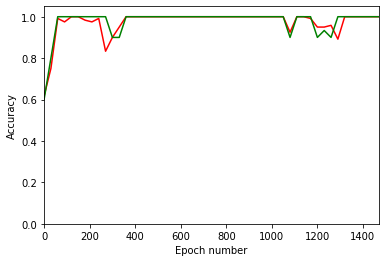

Accuracy: 100.0 %


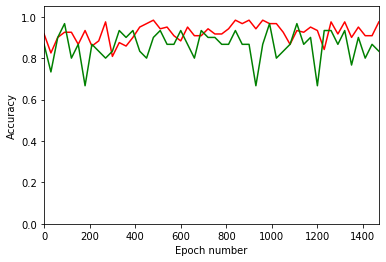

Accuracy: 86.66666666666667 %


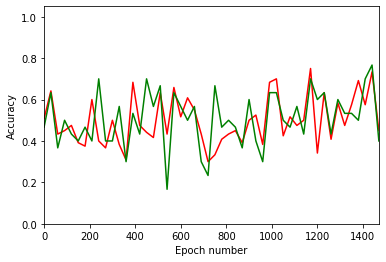

Accuracy: 66.66666666666666 %


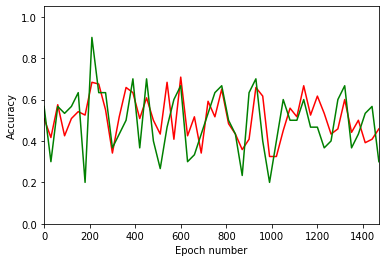

Accuracy: 50.0 %


In [3]:
from utils import Dataset

# Tests on all datasets
for i in range(1,4+1):
    datafile = "data/dataset"+str(i)+"_train.txt"
    data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)

    svm = SVM(data, test_data)
    svm.train(1500, 0.0001)
    svm.make_plot() # Train accuracy in red, test accuracy in green
    svm.print_accuracy()

<h4>Your answer</h4>
As expected, the best performance of the SVM was on the first dataset which is linearly separable. Other models are more and more inaccurate because of the repartition of data in different classes.

<h2>Part 2: Features Maps</h2>

As you know, it is possible to use the "Kernel Trick" to separate non-linearly separable datasets with SVMs. This trick is meant to be applied on the dual problem. As PEGASOS is based on the primal problem, the Kernel Trick cannot be used easily with PEGASOS. However, there is a method to approximate the feature space corresponding to a given kernel. In this part, you will implement and test that method. You will not be asked to dig into the mathematical theory behind that method, but if you wish, you can find more informations in the paper <i>Random Features for Large-Scale Kernel Machines</i> by Ali Rahimi and Ben Recht [1].

<h2>Approximating the Radial Basis Function (RBF) kernel</h2>

The Radial Basis Function $K_\gamma$ is one of the most common kernels used with SVMs. It is defined as follows ($x, y \in \mathbb{R}^d$):

$$ K_\gamma(x, y) = \exp(-\gamma \Vert x - y \Vert^2).$$

Its feature space is of infinite dimension. However, you can approximate it according to the following algorithm (details in [1]):

The pseudo-code above transforms data from its original space to a new feature space approximating the feature space corresponding to the RBF kernel. You will now implement that pseudo-code.

<h4>Question 4</h4>
Complete the following implementation of the FeaturesMap class.

<h4>Your answer</h4>

In [4]:
import numpy as np
from utils import Dataset, PI
from math import cos
import random

class FeaturesMap:

    def __init__(self, dim, old_dim, gamma):
        mean = np.zeros(old_dim)
        cov = 2 * old_dim * gamma * np.eye(old_dim)
        self.dim = dim
        self.omega = [np.random.multivariate_normal(mean, cov) for _ in range(dim)]
        self.b = [random.random()*2*PI for _ in range(dim)]

    def __call__(self, dataset):
        outputs = dataset.output
        inputs = []
        for x in dataset.input:
            new_feats = []
            for i in range(self.dim):
                feat = np.cos(np.dot(self.omega[i], x) + self.b[i])
                new_feats.append(feat)
            new_feats = np.array(new_feats)
            new_feats *= np.sqrt(2/self.dim)
            inputs.append(new_feats)
        new_data = Dataset(input_size=self.dim, length=dataset.len)
        new_data.input = inputs
        new_data.output = outputs
        return new_data

<h4>Question 5</h4>
Test your implementation on the four artificial datasets. Train your SVM during 1500 iterations with $\lambda = 0.0001$. The dimension of the feature space is 200 and $\gamma = 1$. How do your results change with respect to what you found in Question 3?

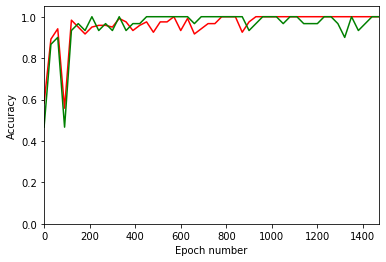

Accuracy: 96.66666666666667 %


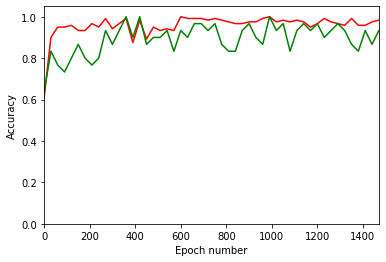

Accuracy: 93.33333333333333 %


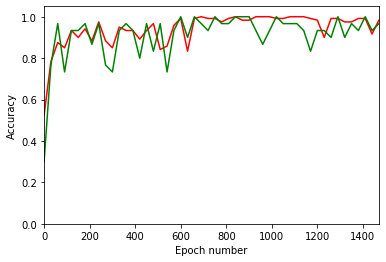

Accuracy: 93.33333333333333 %


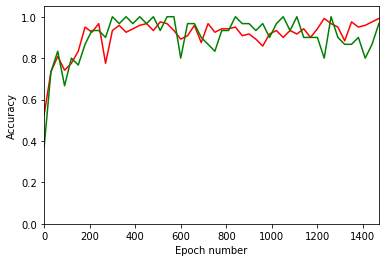

Accuracy: 100.0 %


In [5]:
from utils import Dataset

# Tests on all datasets
for i in range(1,4+1):
    datafile = "data/dataset"+str(i)+"_train.txt"
    data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)

    features_map = FeaturesMap(200, 2, 1)
    new_data = features_map(data)
    new_test_data = features_map(test_data)

    svm = SVM(new_data, new_test_data)
    svm.train(1500, 0.0001)
    svm.make_plot() # Train accuracy in red, test accuracy in green
    svm.print_accuracy()

<h4>Your answer</h4>
The RBF kernel is improving the SVM algorithm: even for non linearly separable (datasets 2,3 and 4), we get much higher accuracies than those of the Question 3.

<h2>The role of $\gamma$ in the RBF kernel</h2>

<h4>Question 6</h4>
Do the same tests with $\gamma = 10^{-6}$. What do you notice? How can you explain your results?

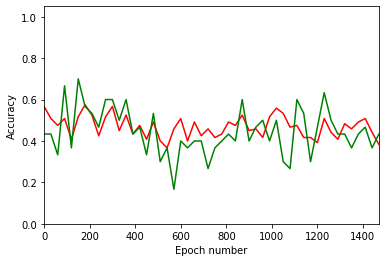

Accuracy: 63.33333333333333 %


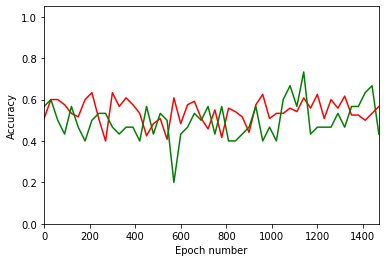

Accuracy: 50.0 %


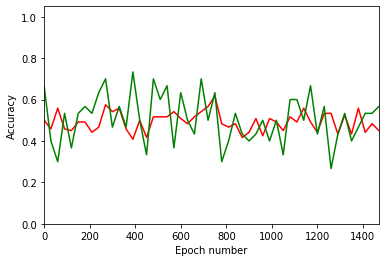

Accuracy: 40.0 %


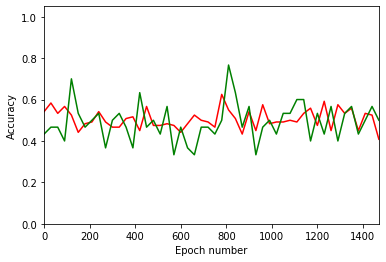

Accuracy: 56.666666666666664 %


In [6]:
from utils import Dataset

# Tests on all datasets
for i in range(1,4+1):
    datafile = "data/dataset"+str(i)+"_train.txt"
    data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)

    features_map = FeaturesMap(200, 2, 1e-6)
    new_data = features_map(data)
    new_test_data = features_map(test_data)

    svm = SVM(new_data, new_test_data)
    svm.train(1500, 0.0001)
    svm.make_plot() # Train accuracy in red, test accuracy in green
    svm.print_accuracy()


The Gaussian parameter $\gamma$ describes how fast the similarity metric (i.e. the euclidian distance between $x_i$ and $x_j$) goes to zero as the two points are close to each others.

When $\gamma$ is close to zero, $ K_\gamma(x, y) = \exp(-\gamma \Vert x - y \Vert^2) \rightarrow 1-\gamma \Vert x - y \Vert^2$: so we have a linear problem. Depending on the value of $\gamma$, the data space can be assigned to only one class, so the model is underfitted. For this reason we obatain low training (and then testing) accuracy (about $50%$).

<h4>Question 7</h4>
Do the same tests with $\gamma = 10^{4}$. What do you notice? How can you explain your results?

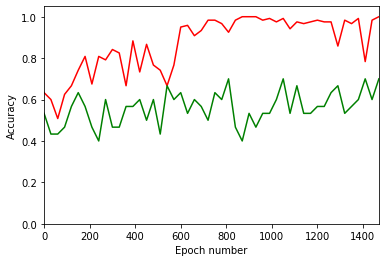

Accuracy: 63.33333333333333 %


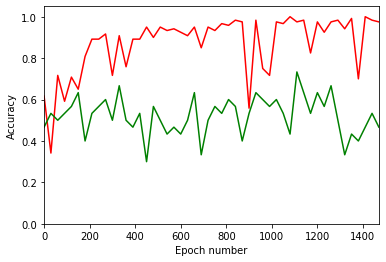

Accuracy: 40.0 %


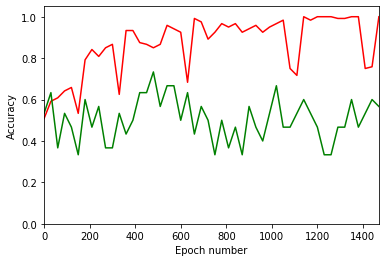

Accuracy: 50.0 %


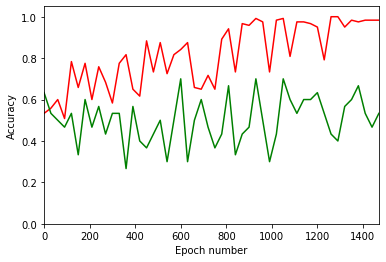

Accuracy: 33.33333333333333 %


In [9]:
from utils import Dataset

# Tests on all datasets
for i in range(1,4+1):
    datafile = "data/dataset"+str(i)+"_train.txt"
    data = Dataset(datafile)
    test_datafile = "data/dataset"+str(i)+"_test.txt"
    test_data = Dataset(test_datafile)

    features_map = FeaturesMap(200, 2, 1e4)
    new_data = features_map(data)
    new_test_data = features_map(test_data)

    svm = SVM(new_data, new_test_data)
    svm.train(1500, 0.0001)
    svm.make_plot() # Train accuracy in red, test accuracy in green
    svm.print_accuracy()

When chosing a high value of $\gamma$, we have $ K_\gamma(x, y) \rightarrow 0$: there is a generalization problem. The model have high accuracies on training data but unable to perform well on unseen data (overfitting error).